<h1 style="font-size:3rem;color:maroon;"> Predicting Air Pollution Level using Machine Learning</h1>

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting air pollution level in an area in Eindhoven in the upcoming week.

We're going to take the following approach:
1. Problem definition
2. Data
3. Features
4. Data Exploration & Visualization
5. Data Preparation
6. Modelling

<h2><font color=slateblue> 1. Problem Definition </font></h2>

In a statement,
> Given historical pollution data, weather data and people going through an area, can we predict air pollution level (fine particle matter level pm2.5) in an area in Eindhoven in the upcoming week?

<h2><font color=slateblue> 2. Data </font></h2>

The data is provided by TNO and Zicht op Data.

<h2><font color=slateblue> 3. Features </font></h2>

This is where you'll get different information about each of the features in our data.

We have three separate datasets for the period between 25-09-2021 and 30-12-2021:

**Air pollution**
* date: date in ymd_hms
* PC4: postcode
* pm2.5: particulate matter <2.5um in ug/m3
* pm10: particulate matter <10um in ug/m3
* no2: nitrogen dioxide in ug/m3
* no: nitrogen oxide in ug/m3
* so2: sulphur dioxide in ug/m3


**Meteo**
* date: date in ymd_hms
* PC4: postcode
* wd: wind direction in degrees 0-360
* ws: wind speed in m/s
* blh: boundary layer height in metres
* tcc: total cloud cover in oktas (0-9)
* ssrd: solar surface radiation downwards in W/m2 

(see https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview for more information)

**Zichtop**
* PC4: postcode
* date: date in ymd_hms
* pop_tot: total number of people in PC4 for each time step
* m00_30: number of people who have been there for up to 30 minutes
* m30_60: number of people who have been there for 30 and 60 minutes
* H1_2: number of people who have been there for 1 and 2 hours
* H2_4: number of people who have been there for 2 and 4 hours
* H4_8: number of people who have been there for 4 and 8 hours
* H8_16: number of people who have been there for 8 and 16 hours
* H16plus: number of people who have been there for over 16 hours

<h2><font color=slateblue> 4. Data Exploration & Visualization </font></h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

                    PC4       pm10      pm2.5        no2         no       so2
date                                                                         
2021-09-25  5633.818182  15.466935   8.721720  26.069080  17.055834  2.437436
2021-09-26  5633.818182  16.939558   7.865281  22.889787  14.975765  3.269219
2021-09-27  5633.818182  10.885686   6.332942  14.544284   9.515675  2.958683
2021-09-28  5633.818182  11.001653   5.581899  19.050652  12.463990  4.460789
2021-09-29  5633.818182   5.619904   2.877056  19.225747  12.578548  2.836495
...                 ...        ...        ...        ...        ...       ...
2021-12-26  5633.818182  33.453445  59.285179  30.420036   1.487488  5.850977
2021-12-27  5633.818182  18.882888  32.962487  25.315250   5.139557  1.217043
2021-12-28  5633.818182   9.041911  13.042438  16.337846   1.707830  1.284986
2021-12-29  5633.818182  14.957415  20.030017  20.412490  10.673166  2.662822
2021-12-30  5633.818182  12.595044  14.113009  11.833592   0.465

<AxesSubplot:xlabel='date'>

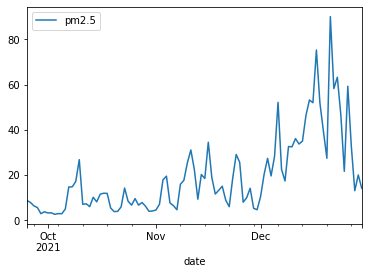

In [2]:
air_pollution_csv = pd.read_csv('data/air_pollution.csv')

air_pollution_csv['date'] = pd.to_datetime(air_pollution_csv['date'], format='%Y-%m-%d')
group_by_day = air_pollution_csv.groupby(pd.Grouper(freq='D', key='date')).mean()

print(group_by_day)

group_by_day.plot(y = 'pm2.5')



In [3]:
air_pollution_csv = pd.read_csv('data/air_pollution.csv')
air_pollution_csv = (pd.to_datetime(air_pollution_csv['date'], format='%Y-%m-%d')
       .dt.floor('d')
       .value_counts()
       .rename_axis('date')
       .reset_index(name='count'))
print(air_pollution_csv)


         date  count
0  2021-11-30    825
1  2021-09-25    792
2  2021-11-13    792
3  2021-12-05    792
4  2021-12-04    792
..        ...    ...
92 2021-10-25    792
93 2021-10-24    792
94 2021-10-23    792
95 2021-10-22    792
96 2021-12-30    759

[97 rows x 2 columns]


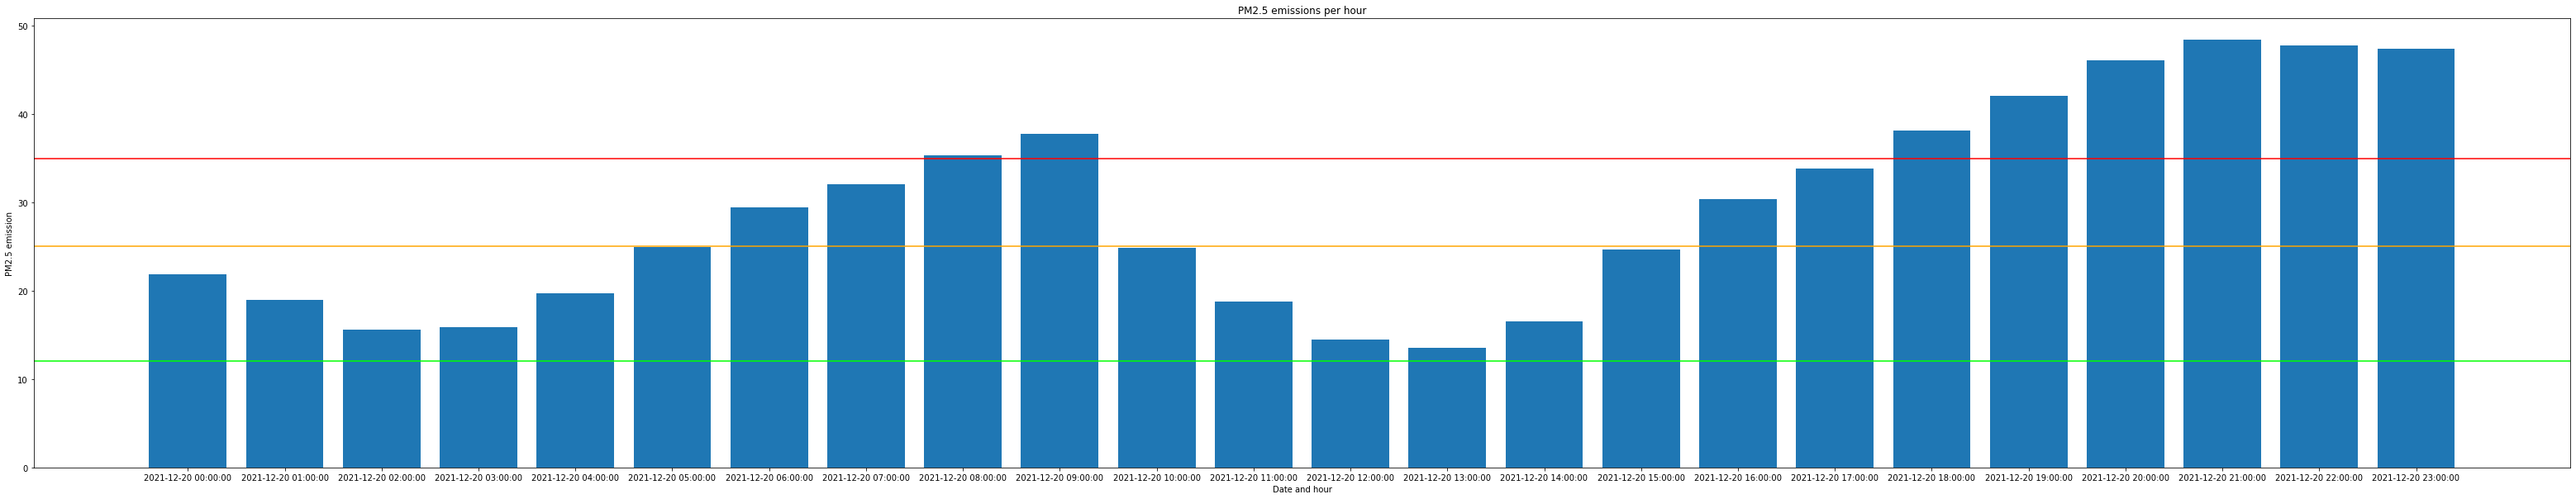

In [11]:
# DOUBLE CLICK ON THE GRAPH TO ZOOM IN #

START_DATE = '2021-12-20'
END_DATE = '2021-12-21'

FIG_HEIGHT = 10
FIG_WIDTH = 55

air_pollution_csv = pd.read_csv('data/air_pollution.csv')

mask = (air_pollution_csv['date'] > START_DATE) & (air_pollution_csv['date'] <= END_DATE)
air_pollution = air_pollution_csv.loc[mask]

x_axis = list(air_pollution.loc[:,'date'])
y_axis = list(air_pollution.loc[:,'pm2.5'])

f = plt.figure()
f.set_figheight(FIG_HEIGHT)
f.set_figwidth(FIG_WIDTH)
plt.bar(x_axis, y_axis)
plt.title("PM2.5 emissions per hour")
plt.xlabel("Date and hour")
plt.ylabel("PM2.5 emission")

healthy_level = [12]
legal_limit = [25]
unhealthy_level = [35]

plt.axhline(y = healthy_level, color = '#00FF00', linestyle = '-')
plt.axhline(y = legal_limit, color = '#FFA500', linestyle = '-')
plt.axhline(y = unhealthy_level, color = '#FF0000', linestyle = '-')

plt.show()

<h2><font color=slateblue> 5. Data Preparation </font></h2>

<h2><font color=slateblue> 6. Modelling </font></h2>